In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 100 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.2849
0 -> 5 -> 3 -> 17 -> 1 -> 12 -> 4 -> 18 -> 9 -> 16 -> 7 -> 2 -> 14 -> 6 -> 13 -> 11 -> 19 -> 8 -> 15 -> 10 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 143.63it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 119.84it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.77it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train) # with binding constr

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 61.26it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-10, num_epochs+10)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 50), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
lr = 5e-2
num_epochs = 400
log_step = 20

In [11]:
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(42)
    torch.manual_seed(42)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    # init log
    loss_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # early stop
            if stopper.stop(regret_val):
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass)
            loss = forward_func(data, reg, loss_func)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # regret
    regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
    regret_log_trn.append(regret_trn)
    regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
    regret_log_val.append(regret_val)
    tbar.write("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, loss.item(), regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                    loader_train_cost, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:01<?, ?it/s]

Epoch   0, Train Regret: 229.1573%, Val Regret: 226.7782%


Epoch   19, Loss:  16.8684:   5%|██▋                                                  | 20/400 [00:24<06:27,  1.02s/it]

Epoch  20, Train Regret:  22.2205%, Val Regret:  24.4857%


Epoch   39, Loss:  12.0736:  10%|█████▎                                               | 40/400 [00:47<06:05,  1.02s/it]

Epoch  40, Train Regret:  20.3812%, Val Regret:  20.9463%


Epoch   59, Loss:  17.6182:  15%|███████▉                                             | 60/400 [01:09<05:45,  1.02s/it]

Epoch  60, Train Regret:  17.4124%, Val Regret:  18.4560%


Epoch   79, Loss:  11.7675:  20%|██████████▌                                          | 80/400 [01:31<05:25,  1.02s/it]

Epoch  80, Train Regret:  16.2709%, Val Regret:  16.4961%


Epoch   99, Loss:   6.9176:  25%|█████████████                                       | 100/400 [01:53<05:05,  1.02s/it]

Epoch 100, Train Regret:  15.8802%, Val Regret:  17.2513%


Epoch  119, Loss:   6.7721:  30%|███████████████▌                                    | 120/400 [02:15<04:44,  1.01s/it]

Epoch 120, Train Regret:  16.3900%, Val Regret:  16.9215%


Epoch  139, Loss:   6.2329:  35%|██████████████████▏                                 | 140/400 [02:37<04:24,  1.02s/it]

Epoch 140, Train Regret:  15.3825%, Val Regret:  16.2233%


Epoch  159, Loss:  16.3241:  40%|████████████████████▊                               | 160/400 [02:59<04:03,  1.02s/it]

Epoch 160, Train Regret:  14.9757%, Val Regret:  16.5433%


Epoch  179, Loss:   6.1063:  45%|███████████████████████▍                            | 180/400 [03:20<03:43,  1.02s/it]

Epoch 180, Train Regret:  15.4667%, Val Regret:  16.9749%


Epoch  199, Loss:   4.2576:  50%|██████████████████████████                          | 200/400 [03:42<03:42,  1.11s/it]


Epoch 200, Train Regret:  15.1048%, Val Regret:  16.4125%
Early Stop!
Epoch 200, Loss:   4.2576, Train Regret:  15.1048%, Val Regret:  16.4125%

Evaluation:
Test Regret: 16.4118%
Training Elapsed Time: 3.03 Sec


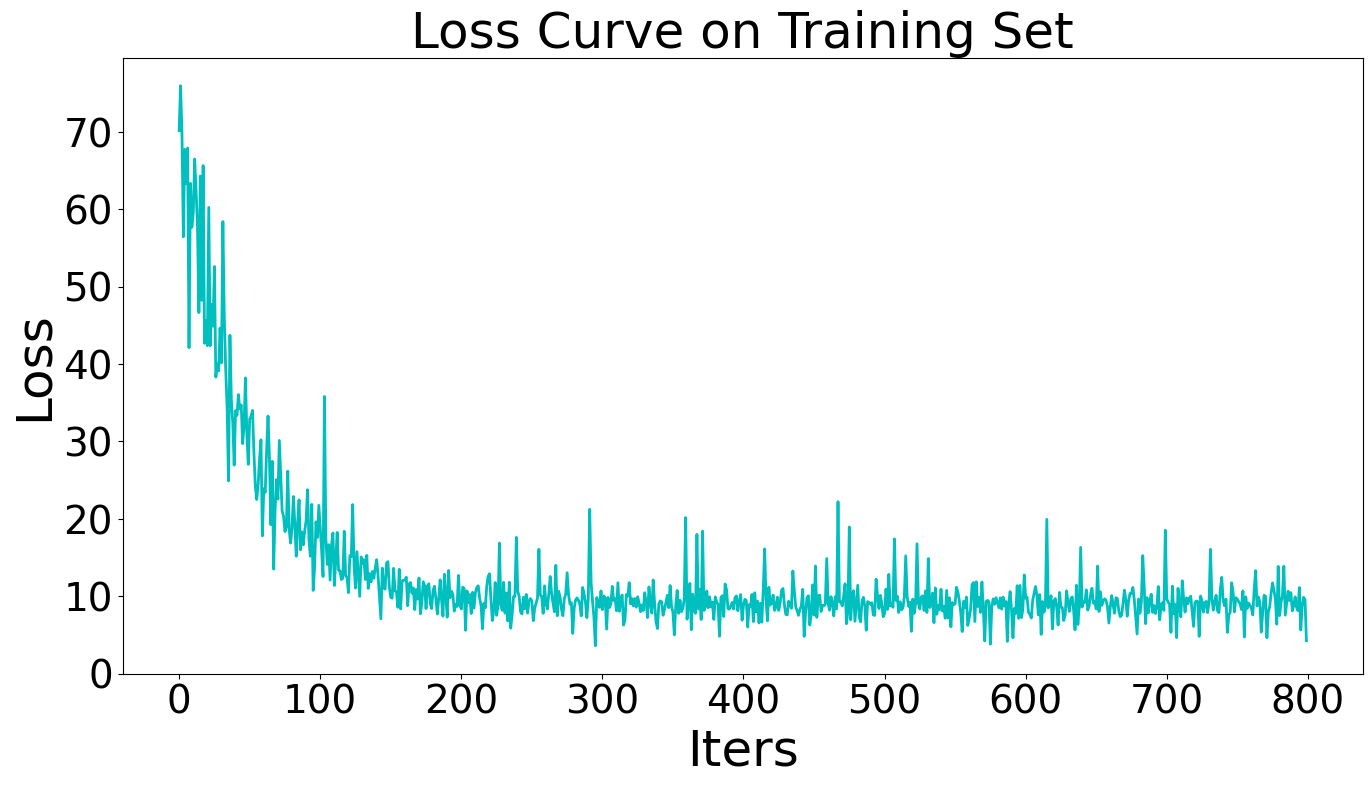

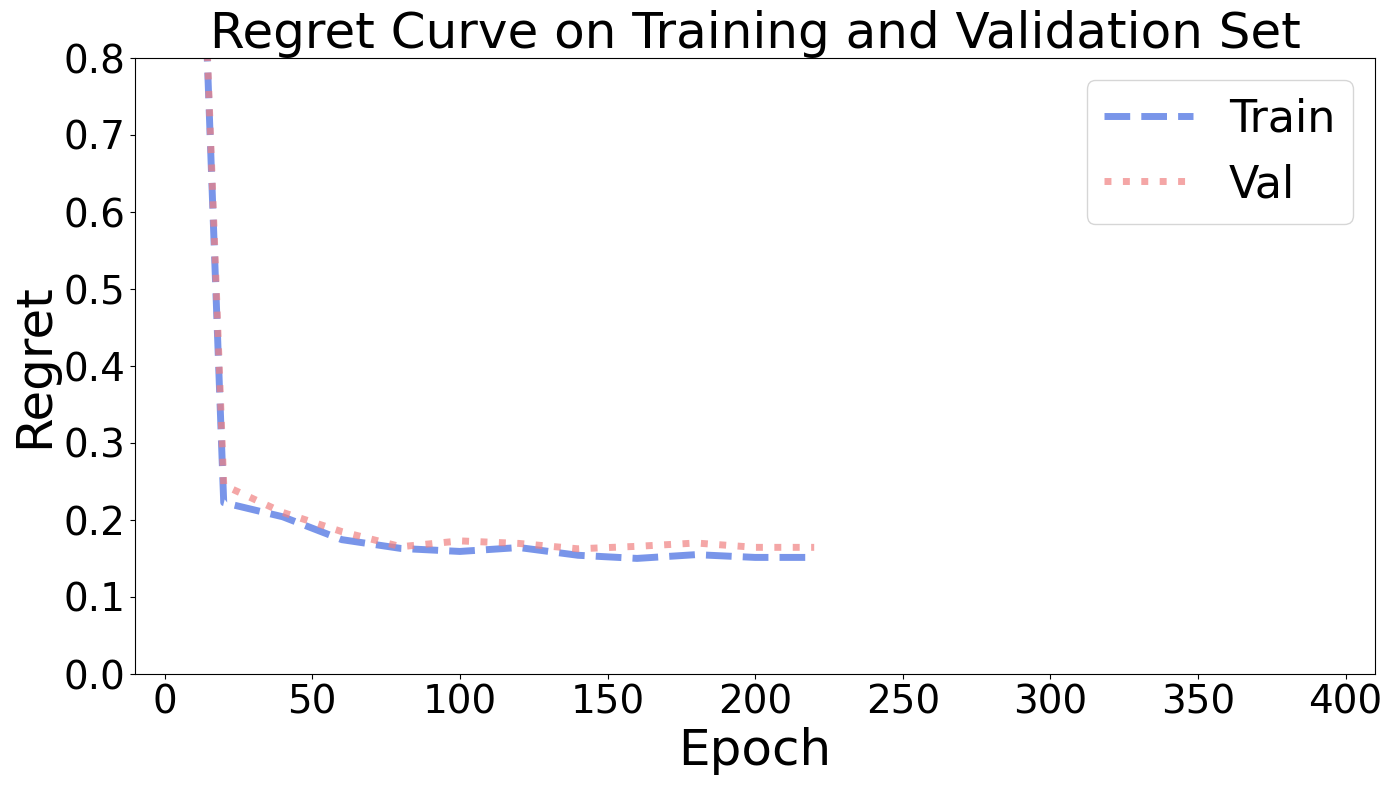

In [15]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method 

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, processes=8)

Num of cores: 8


In [18]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:01<?, ?it/s]

Epoch   0, Train Regret: 197.6313%, Val Regret: 198.0874%


Epoch   19, Loss:  -0.9999:   5%|██▋                                                  | 20/400 [00:36<09:17,  1.47s/it]

Epoch  20, Train Regret:   9.4331%, Val Regret:  29.0888%


Epoch   39, Loss:  -1.0000:  10%|█████▎                                               | 40/400 [01:08<09:05,  1.51s/it]

Epoch  40, Train Regret:   6.2086%, Val Regret:  29.2798%


Epoch   59, Loss:  -1.0000:  15%|███████▉                                             | 60/400 [01:41<08:40,  1.53s/it]

Epoch  60, Train Regret:   3.8915%, Val Regret:  29.2022%


Epoch   79, Loss:  -1.0000:  20%|██████████▌                                          | 80/400 [02:13<08:55,  1.67s/it]


Epoch  80, Train Regret:   1.2716%, Val Regret:  29.3192%
Early Stop!
Epoch  80, Loss:  -1.0000, Train Regret:   1.2716%, Val Regret:  29.3192%

Evaluation:
Test Regret: 25.3622%
Training Elapsed Time: 44.15 Sec


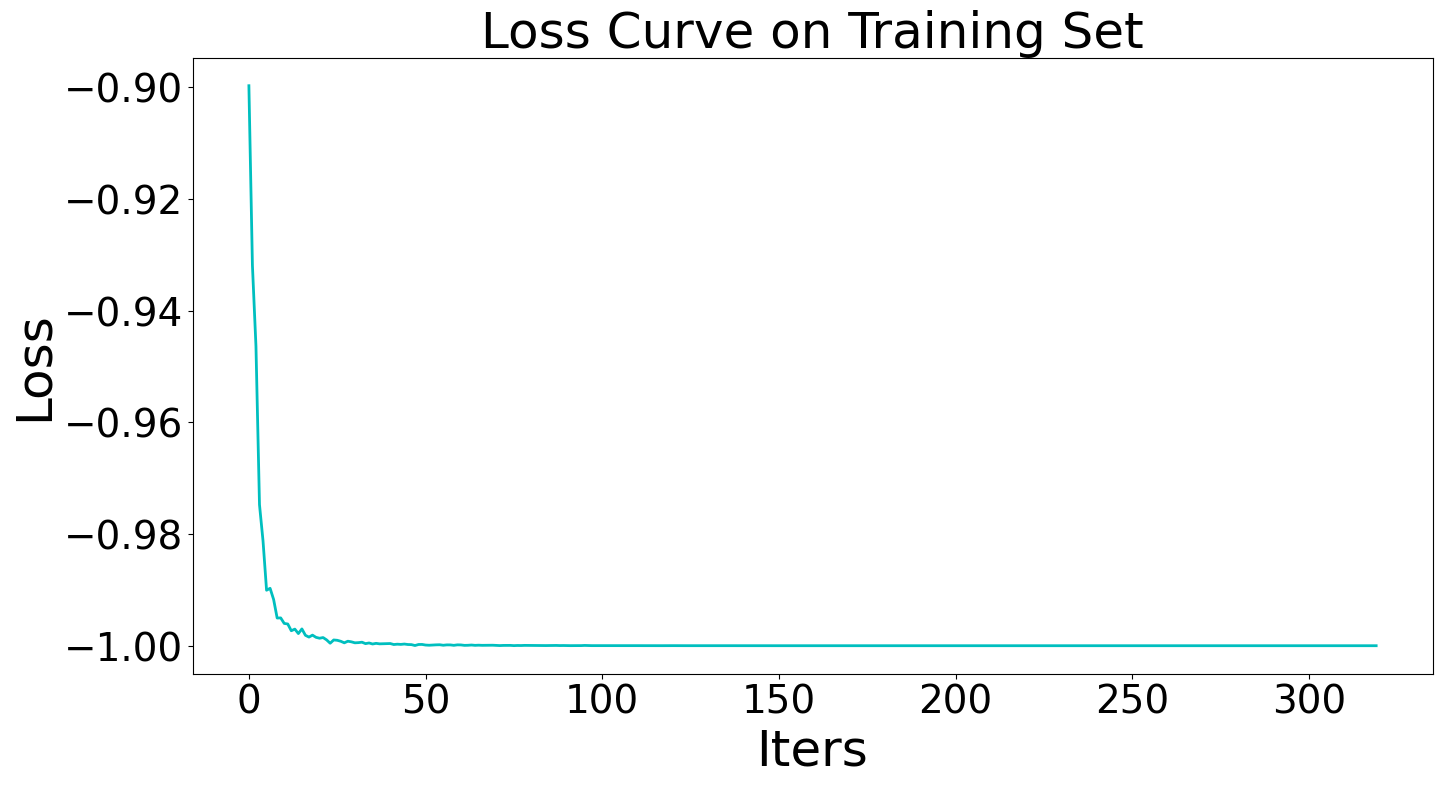

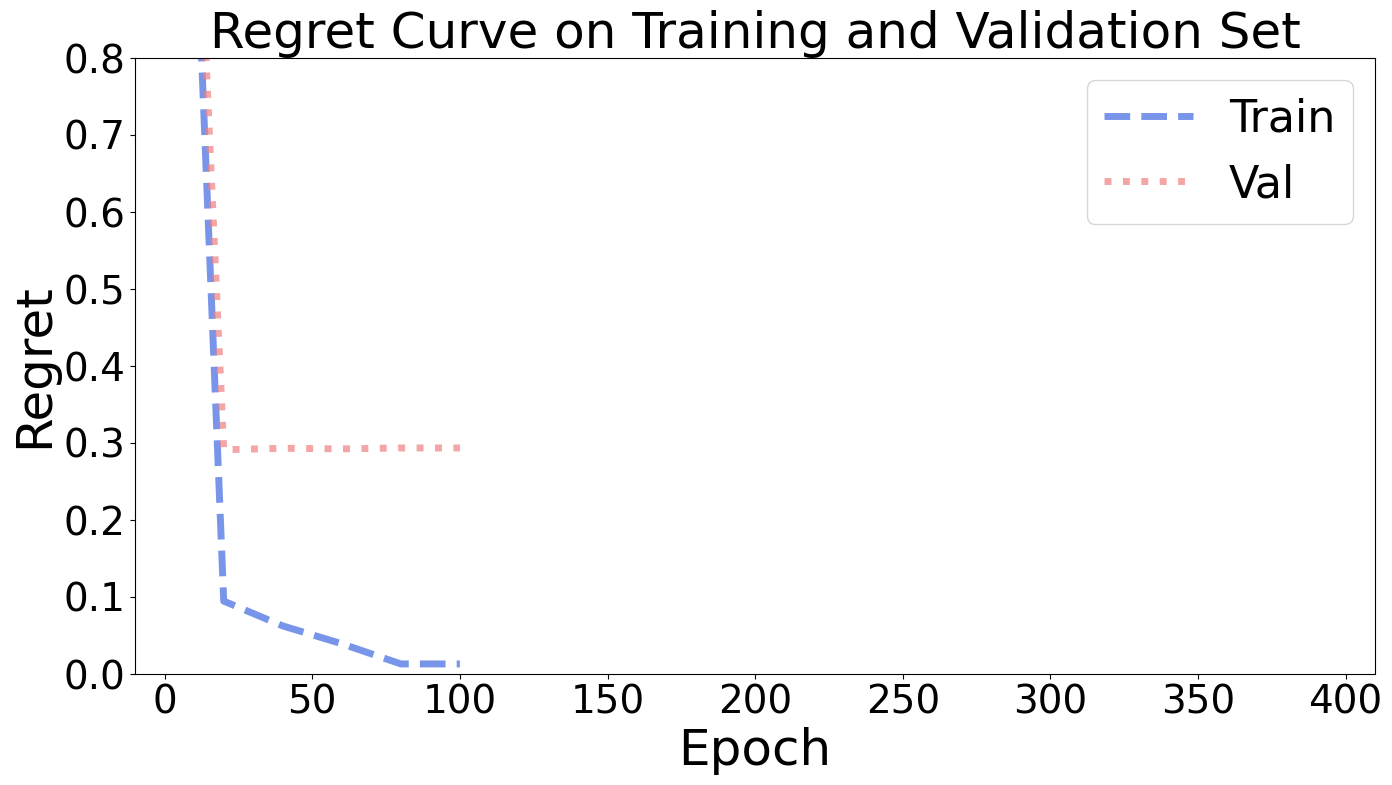

In [19]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NNLS Method 

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import nnlsConeAlignedCosine
# init loss
ca_cos = nnlsConeAlignedCosine(optmodel, processes=8)

Num of cores: 8


In [22]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:01<?, ?it/s]

Epoch   0, Train Regret: 219.9754%, Val Regret: 210.3004%


Epoch   19, Loss:  -0.9999:   5%|██▋                                                  | 20/400 [00:29<08:03,  1.27s/it]

Epoch  20, Train Regret:  12.3462%, Val Regret:  27.2222%


Epoch   39, Loss:  -1.0000:  10%|█████▎                                               | 40/400 [00:56<07:43,  1.29s/it]

Epoch  40, Train Regret:   8.4627%, Val Regret:  26.7632%


Epoch   59, Loss:  -1.0000:  15%|███████▉                                             | 60/400 [01:23<07:10,  1.27s/it]

Epoch  60, Train Regret:   7.0889%, Val Regret:  26.2156%


Epoch   79, Loss:  -1.0000:  20%|██████████▌                                          | 80/400 [01:50<06:46,  1.27s/it]

Epoch  80, Train Regret:   4.1090%, Val Regret:  26.2016%


Epoch   99, Loss:  -1.0000:  25%|█████████████                                       | 100/400 [02:18<06:24,  1.28s/it]

Epoch 100, Train Regret:   2.7240%, Val Regret:  26.0037%


Epoch  119, Loss:  -1.0000:  30%|███████████████▌                                    | 120/400 [02:45<06:00,  1.29s/it]

Epoch 120, Train Regret:   1.2141%, Val Regret:  26.0037%


Epoch  139, Loss:  -1.0000:  35%|██████████████████▏                                 | 140/400 [03:12<05:28,  1.27s/it]

Epoch 140, Train Regret:   0.0561%, Val Regret:  26.0037%


Epoch  159, Loss:  -1.0000:  40%|████████████████████▊                               | 160/400 [03:39<05:29,  1.37s/it]


Epoch 160, Train Regret:   0.0000%, Val Regret:  26.0037%
Early Stop!
Epoch 160, Loss:  -1.0000, Train Regret:   0.0000%, Val Regret:  26.0037%

Evaluation:
Test Regret: 26.1599%
Training Elapsed Time: 42.57 Sec


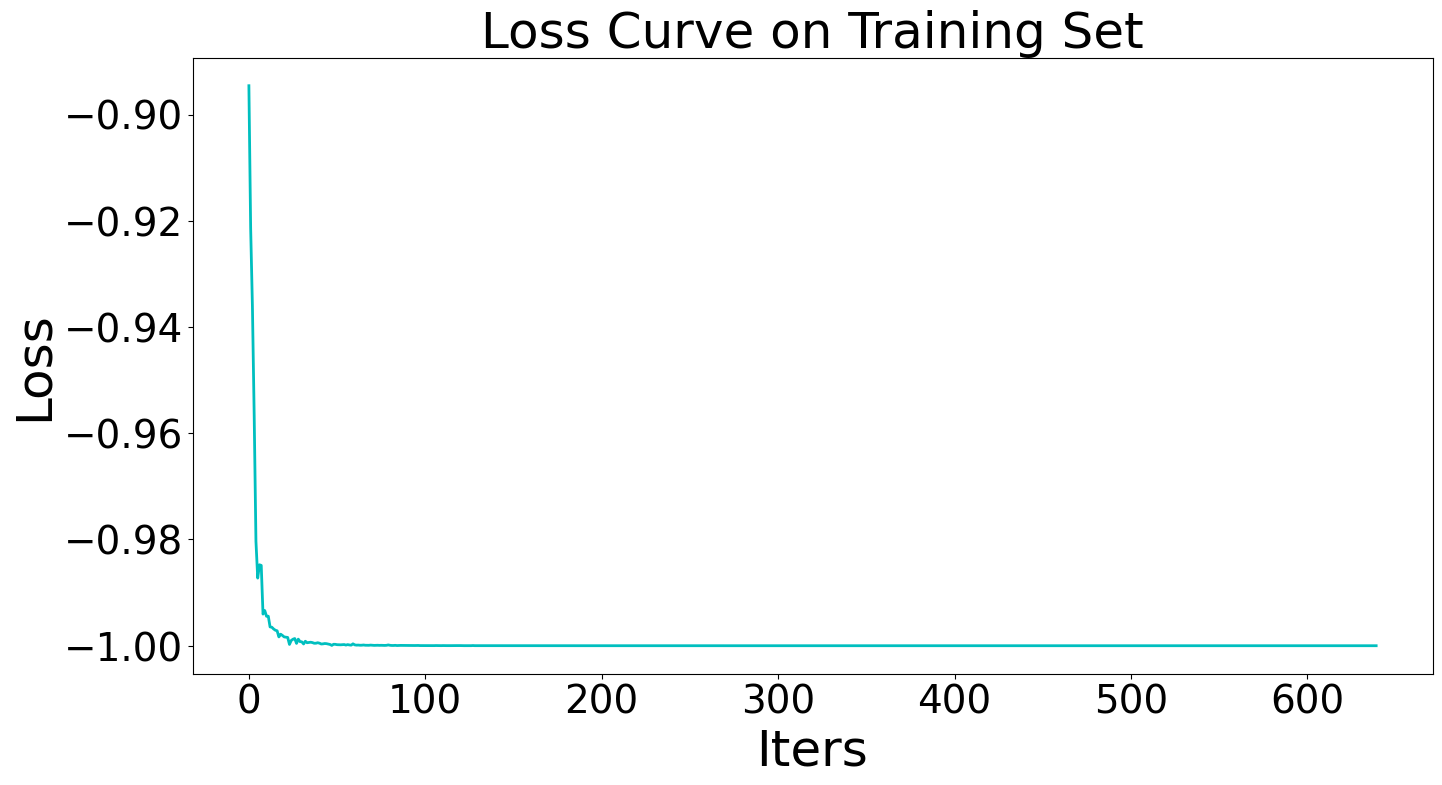

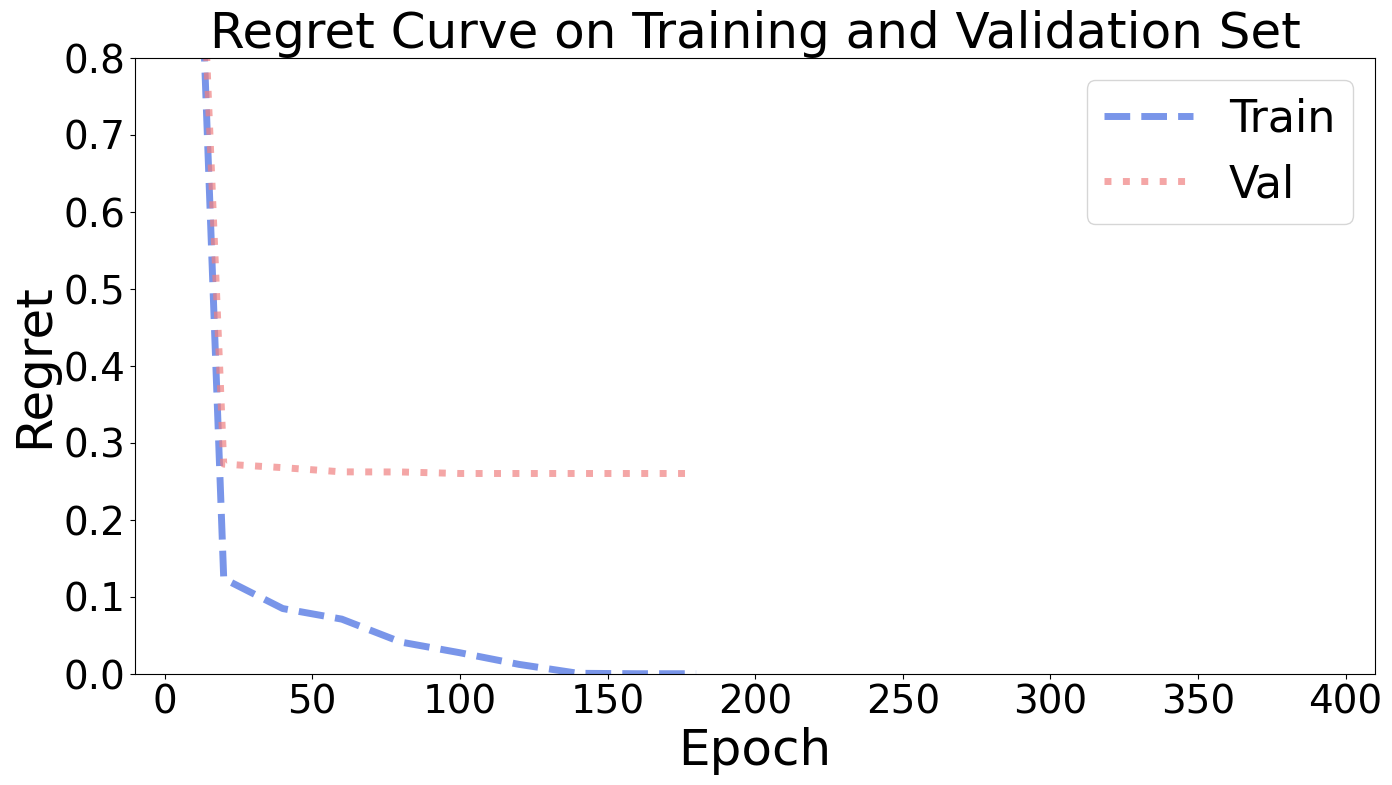

In [23]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [26]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:01<?, ?it/s]

Epoch   0, Train Regret: 218.4324%, Val Regret: 212.6640%


Epoch   19, Loss:  -0.7866:   5%|██▋                                                  | 20/400 [00:25<07:00,  1.11s/it]

Epoch  20, Train Regret:  16.9870%, Val Regret:  25.5817%


Epoch   39, Loss:  -0.7620:  10%|█████▎                                               | 40/400 [00:49<06:40,  1.11s/it]

Epoch  40, Train Regret:  16.0812%, Val Regret:  25.3686%


Epoch   59, Loss:  -0.7876:  15%|███████▉                                             | 60/400 [01:13<06:16,  1.11s/it]

Epoch  60, Train Regret:  15.2330%, Val Regret:  23.9947%


Epoch   79, Loss:  -0.7805:  20%|██████████▌                                          | 80/400 [01:37<05:53,  1.10s/it]

Epoch  80, Train Regret:  14.5429%, Val Regret:  24.5477%


Epoch   99, Loss:  -0.7779:  25%|█████████████                                       | 100/400 [02:01<05:31,  1.11s/it]

Epoch 100, Train Regret:  15.0635%, Val Regret:  25.6819%


Epoch  119, Loss:  -0.7756:  30%|███████████████▌                                    | 120/400 [02:25<05:38,  1.21s/it]


Epoch 120, Train Regret:  15.0856%, Val Regret:  25.8783%
Early Stop!
Epoch 120, Loss:  -0.7756, Train Regret:  15.0856%, Val Regret:  25.8783%

Evaluation:
Test Regret: 23.6539%
Training Elapsed Time: 11.69 Sec


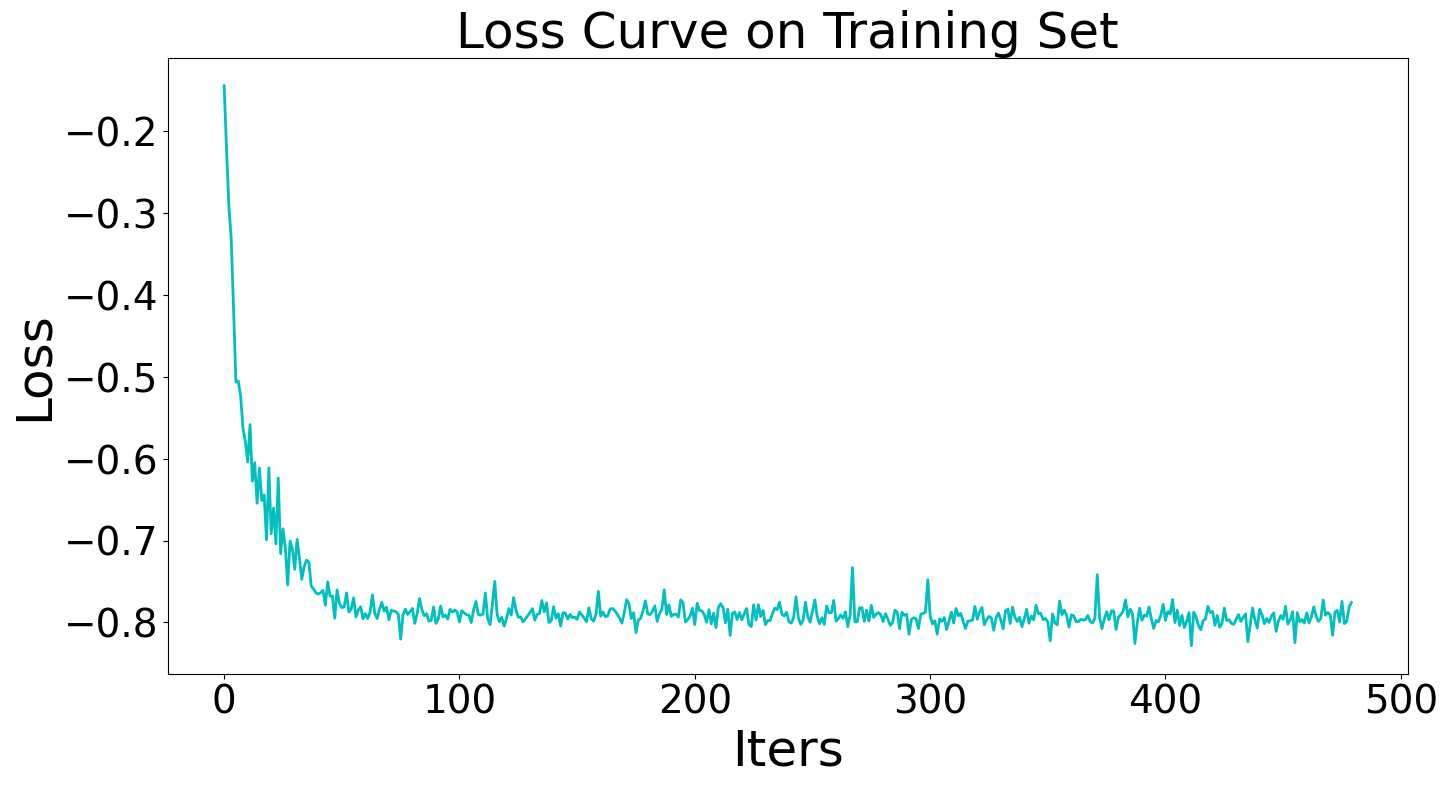

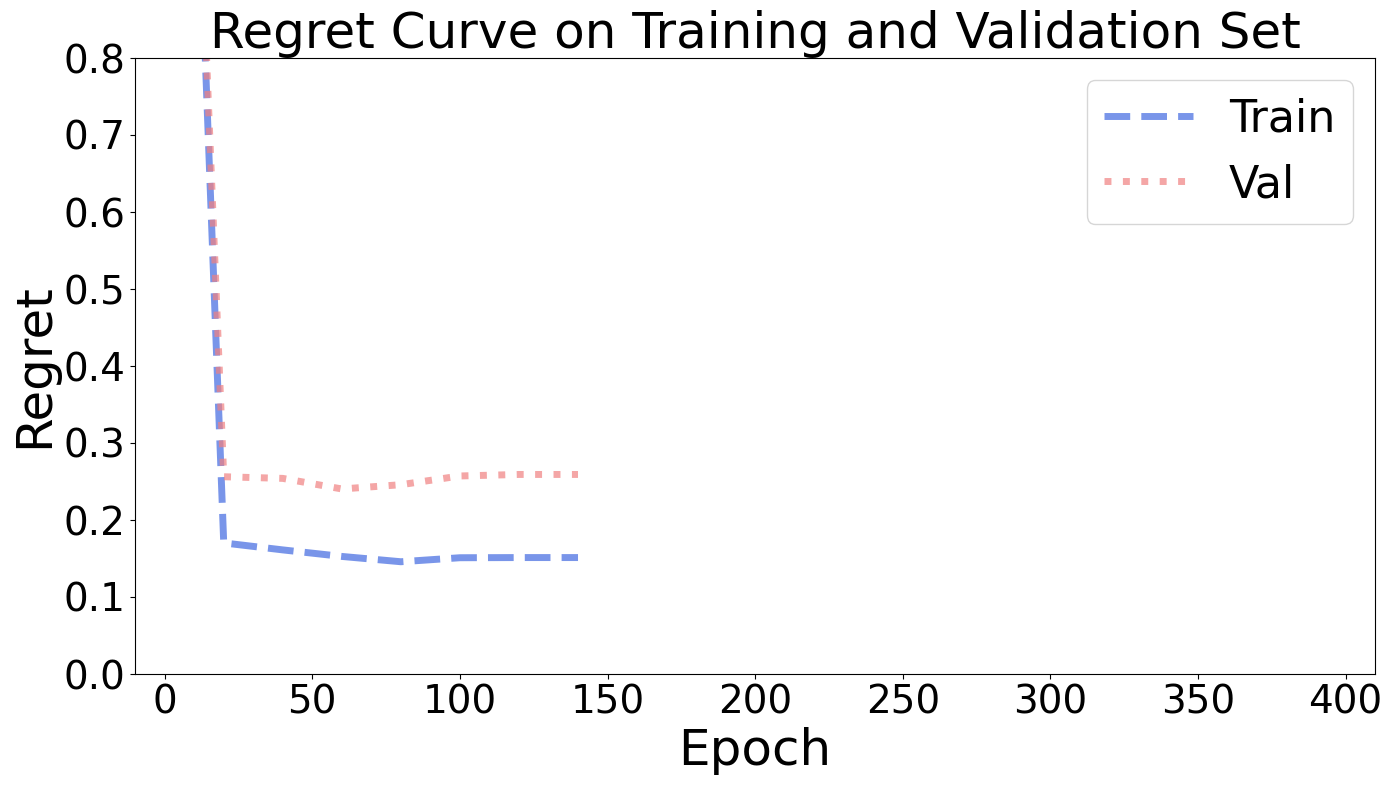

In [27]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

In [30]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:01<?, ?it/s]

Epoch   0, Train Regret: 193.5132%, Val Regret: 196.8861%


Epoch   19, Loss:  -0.8509:   5%|██▋                                                  | 20/400 [00:24<06:32,  1.03s/it]

Epoch  20, Train Regret:  14.7490%, Val Regret:  21.9335%


Epoch   39, Loss:  -0.8551:  10%|█████▎                                               | 40/400 [00:46<06:10,  1.03s/it]

Epoch  40, Train Regret:  15.7017%, Val Regret:  22.5114%


Epoch   59, Loss:  -0.7902:  15%|███████▉                                             | 60/400 [01:09<05:50,  1.03s/it]

Epoch  60, Train Regret:  13.9902%, Val Regret:  25.5681%


Epoch   79, Loss:  -0.7827:  20%|██████████▌                                          | 80/400 [01:31<06:06,  1.15s/it]


Epoch  80, Train Regret:  14.6163%, Val Regret:  23.8474%
Early Stop!
Epoch  80, Loss:  -0.7827, Train Regret:  14.6163%, Val Regret:  23.8474%

Evaluation:
Test Regret: 23.3435%
Training Elapsed Time: 1.60 Sec


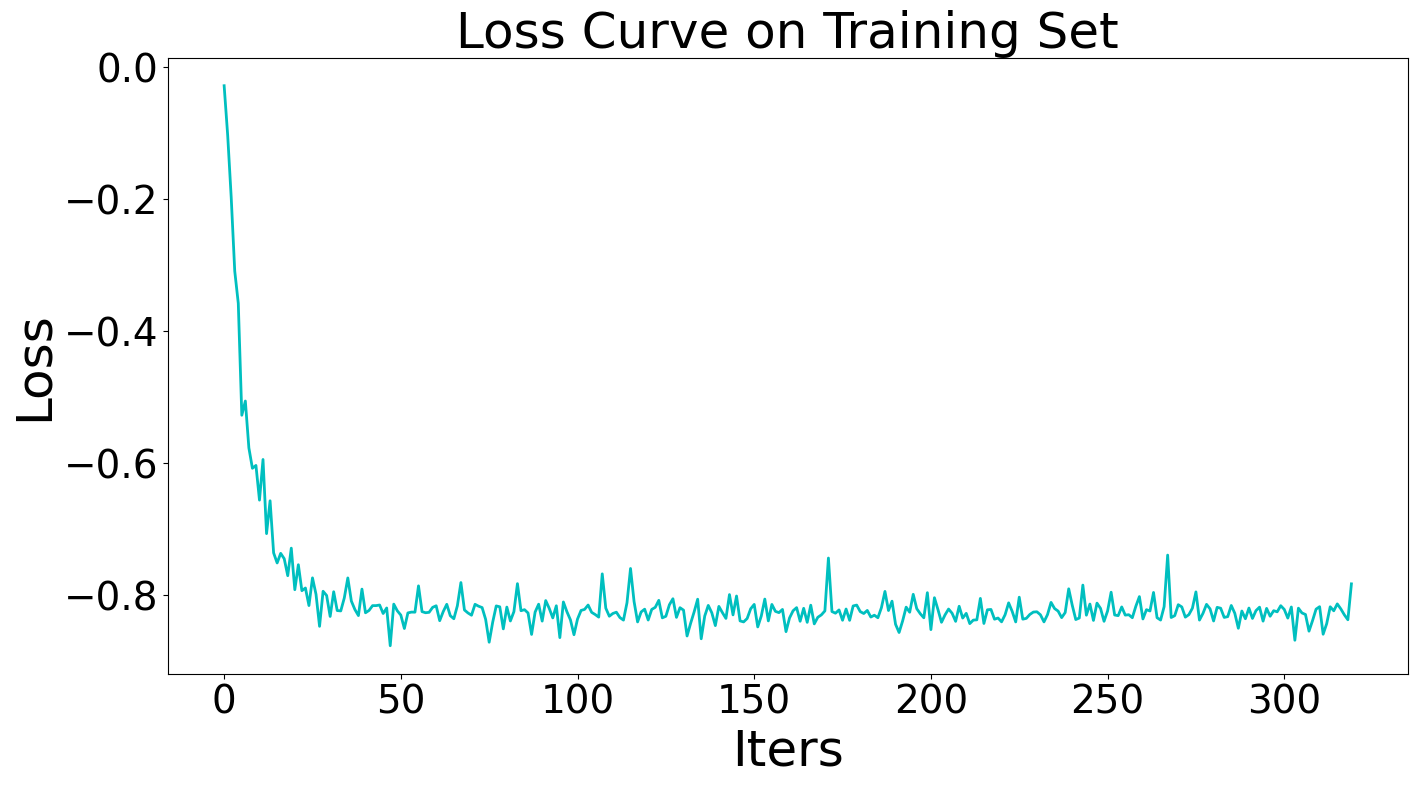

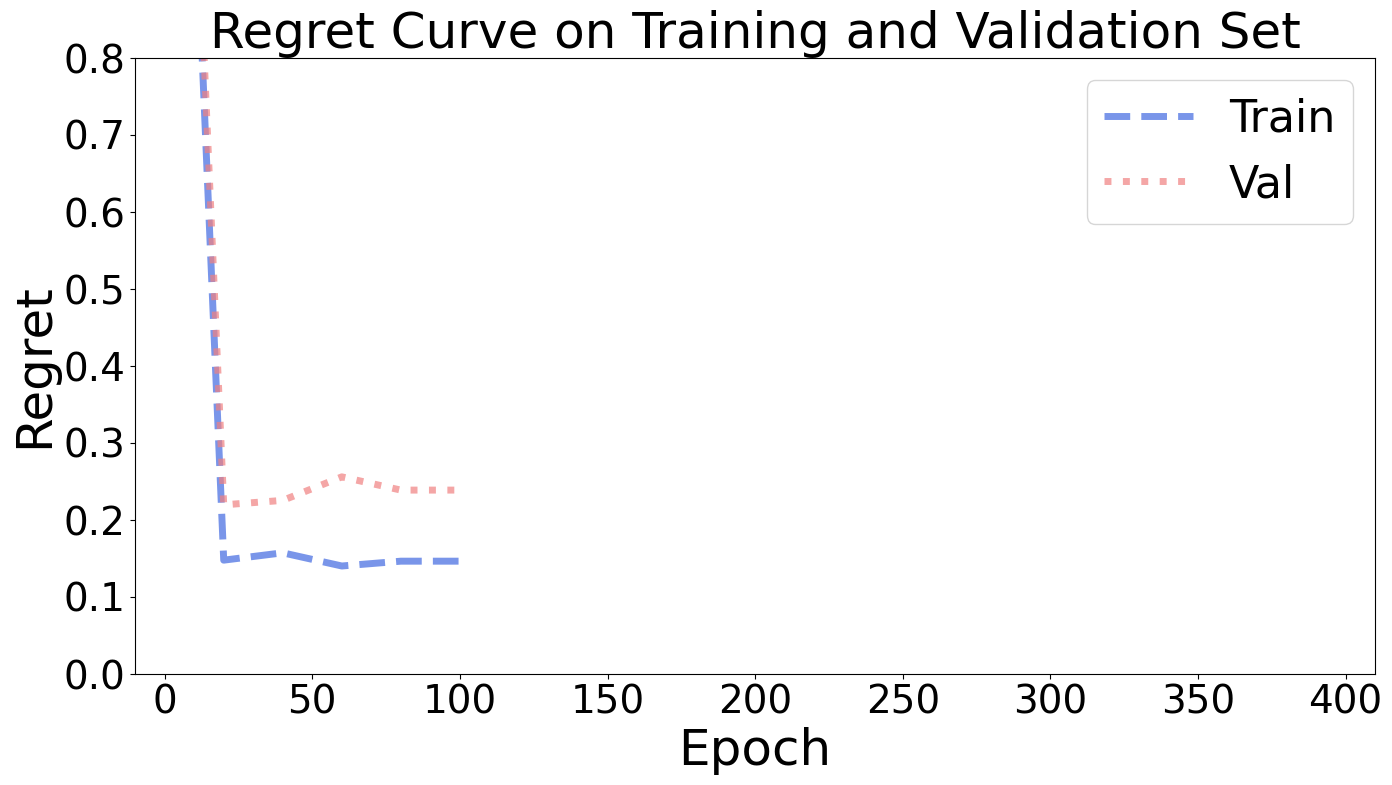

In [31]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sign Method 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import signConeAlignedCosine
# init loss
ca_cos = signConeAlignedCosine(optmodel)

In [34]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:01<?, ?it/s]

Epoch   0, Train Regret: 219.9754%, Val Regret: 210.3004%


Epoch   19, Loss:  -0.9983:   5%|██▋                                                  | 20/400 [00:24<06:30,  1.03s/it]

Epoch  20, Train Regret:  16.3707%, Val Regret:  35.9370%


Epoch   39, Loss:  -0.9995:  10%|█████▎                                               | 40/400 [00:46<06:10,  1.03s/it]

Epoch  40, Train Regret:  13.9556%, Val Regret:  34.2846%


Epoch   59, Loss:  -0.9995:  15%|███████▉                                             | 60/400 [01:08<05:49,  1.03s/it]

Epoch  60, Train Regret:  15.8548%, Val Regret:  35.8471%


Epoch   79, Loss:  -0.9997:  20%|██████████▌                                          | 80/400 [01:30<05:29,  1.03s/it]

Epoch  80, Train Regret:  14.8990%, Val Regret:  36.9851%


Epoch   99, Loss:  -0.9995:  25%|█████████████                                       | 100/400 [01:53<05:39,  1.13s/it]


Epoch 100, Train Regret:  15.1283%, Val Regret:  39.6699%
Early Stop!
Epoch 100, Loss:  -0.9995, Train Regret:  15.1283%, Val Regret:  39.6699%

Evaluation:
Test Regret: 34.8713%
Training Elapsed Time: 2.08 Sec


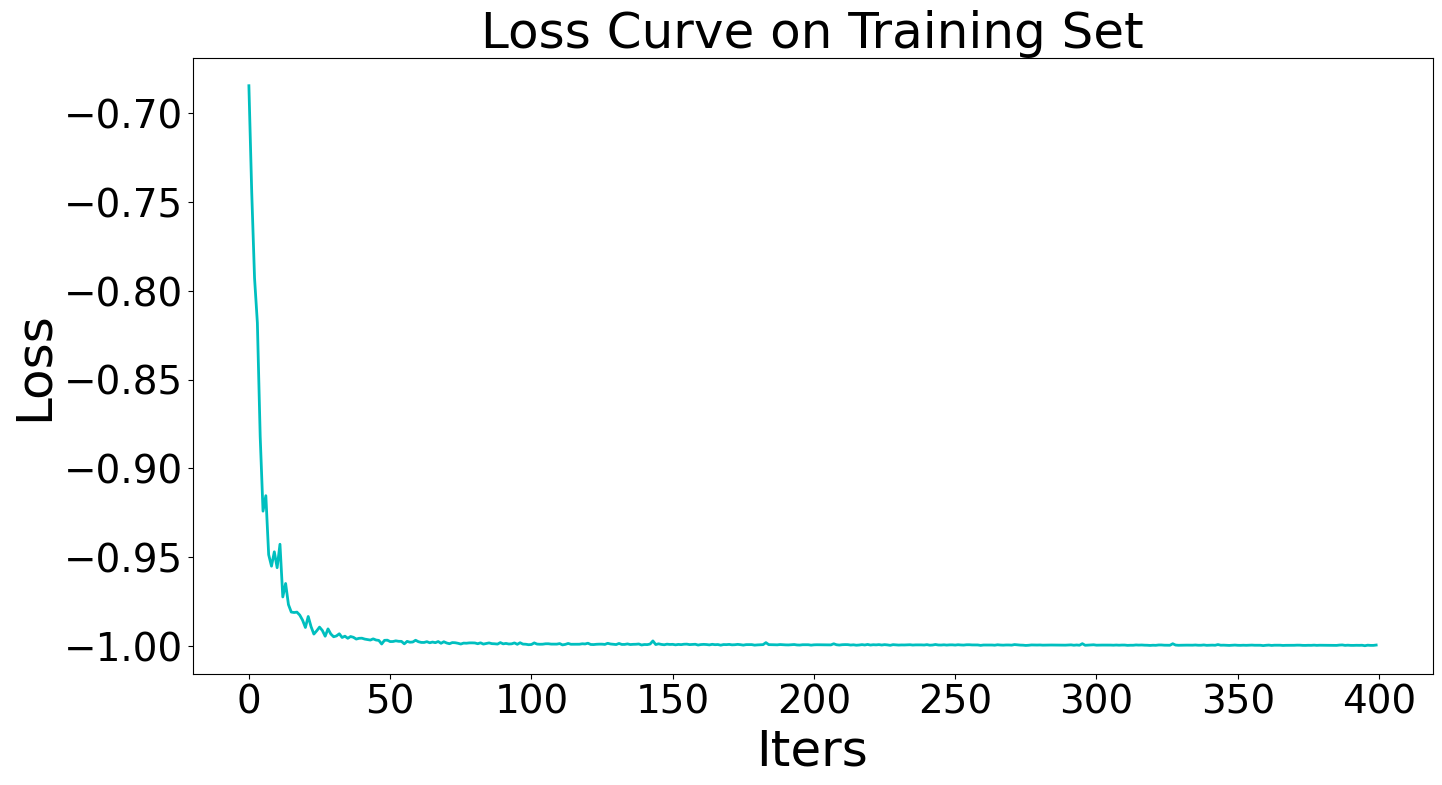

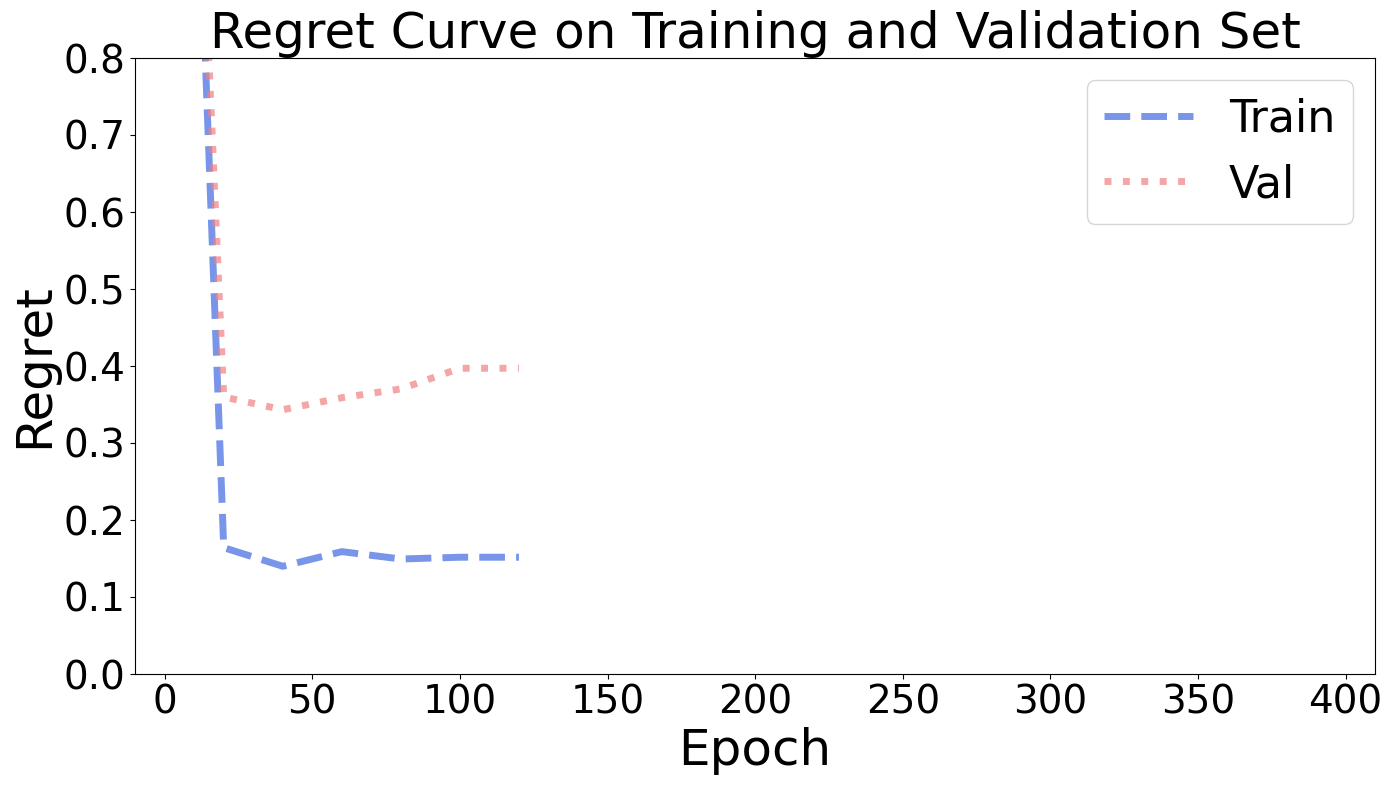

In [35]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [38]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:01<?, ?it/s]

Epoch   0, Train Regret: 197.9496%, Val Regret: 193.2480%


Epoch   19, Loss:  14.0000:   5%|██▋                                                  | 20/400 [00:30<08:23,  1.33s/it]

Epoch  20, Train Regret:   6.3577%, Val Regret:  18.4624%


Epoch   39, Loss:   4.0000:  10%|█████▎                                               | 40/400 [00:58<08:15,  1.38s/it]

Epoch  40, Train Regret:   4.9446%, Val Regret:  18.6917%


Epoch   59, Loss:  12.0000:  15%|███████▉                                             | 60/400 [01:26<07:30,  1.33s/it]

Epoch  60, Train Regret:   2.7536%, Val Regret:  17.3873%


Epoch   79, Loss:   9.5000:  20%|██████████▌                                          | 80/400 [01:54<06:59,  1.31s/it]

Epoch  80, Train Regret:   2.4957%, Val Regret:  17.8299%


Epoch   99, Loss:  10.5000:  25%|█████████████                                       | 100/400 [02:22<06:32,  1.31s/it]

Epoch 100, Train Regret:   2.3158%, Val Regret:  17.1618%


Epoch  119, Loss:   6.0000:  30%|███████████████▌                                    | 120/400 [02:50<06:14,  1.34s/it]

Epoch 120, Train Regret:   1.6133%, Val Regret:  17.9300%


Epoch  139, Loss:  12.5000:  35%|██████████████████▏                                 | 140/400 [03:19<05:52,  1.36s/it]

Epoch 140, Train Regret:   1.4749%, Val Regret:  16.7802%


Epoch  159, Loss:   4.5000:  40%|████████████████████▊                               | 160/400 [03:47<05:13,  1.31s/it]

Epoch 160, Train Regret:   1.1179%, Val Regret:  18.0495%


Epoch  179, Loss:   6.0000:  45%|███████████████████████▍                            | 180/400 [04:15<04:50,  1.32s/it]

Epoch 180, Train Regret:   1.2201%, Val Regret:  17.1694%


Epoch  199, Loss:   6.0000:  50%|██████████████████████████                          | 200/400 [04:43<04:43,  1.42s/it]


Epoch 200, Train Regret:   1.0302%, Val Regret:  17.8053%
Early Stop!
Epoch 200, Loss:   6.0000, Train Regret:   1.0302%, Val Regret:  17.8053%

Evaluation:
Test Regret: 17.2057%
Training Elapsed Time: 63.16 Sec


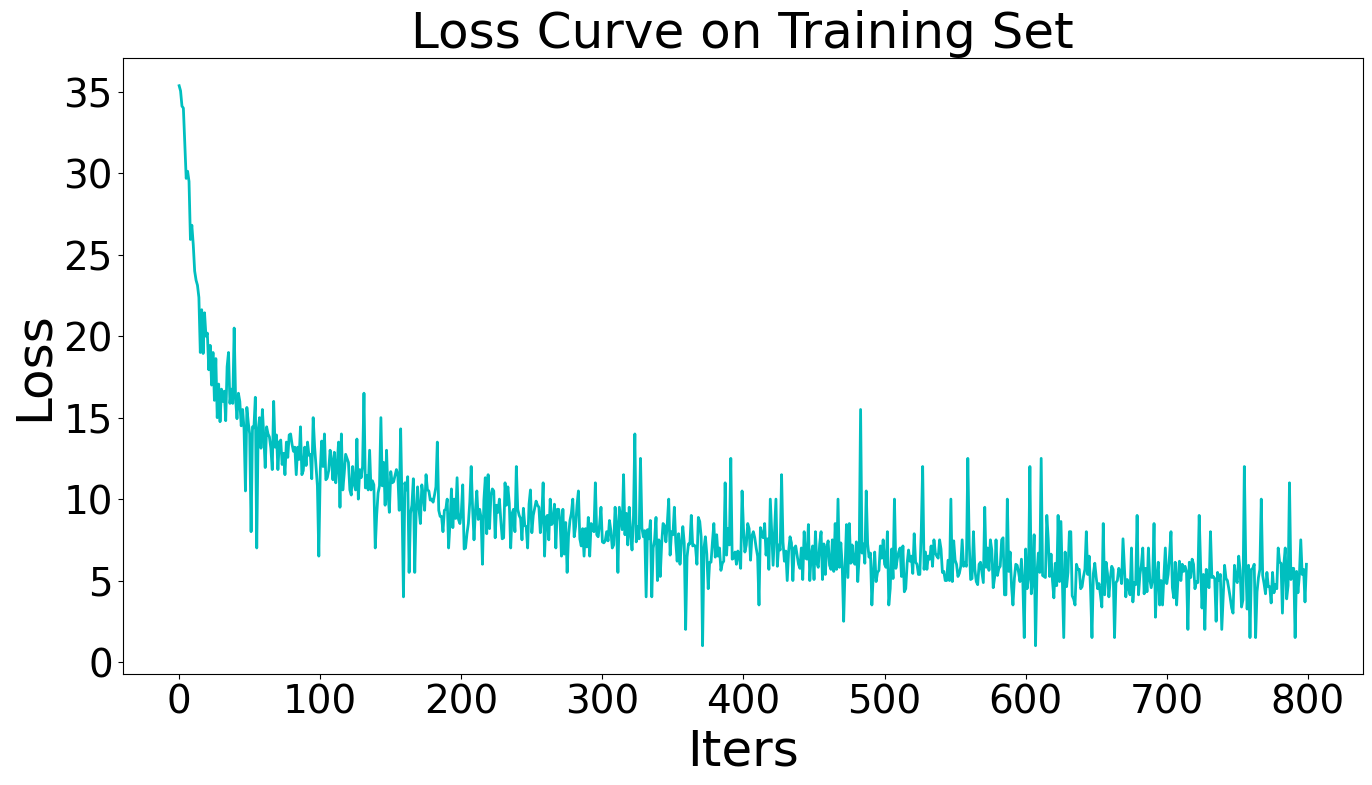

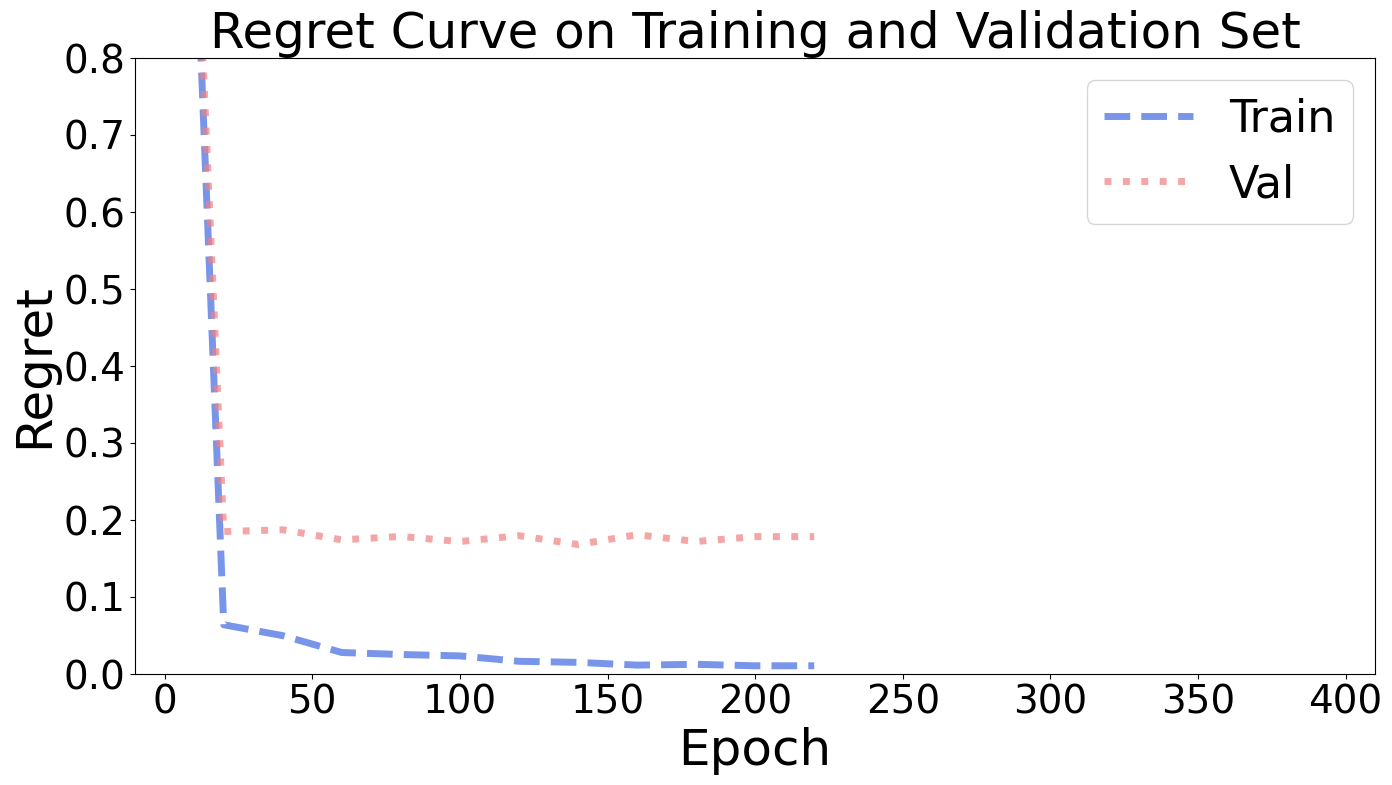

In [39]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [40]:
# init model
reg = LinearRegression()

In [41]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [42]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/400 [00:01<?, ?it/s]

Epoch   0, Train Regret: 197.6313%, Val Regret: 198.0874%


Epoch   19, Loss: -207.5468:   5%|██▌                                                 | 20/400 [00:24<06:39,  1.05s/it]

Epoch  20, Train Regret:  18.8352%, Val Regret:  31.9466%


Epoch   39, Loss: -355.3186:  10%|█████▏                                              | 40/400 [00:47<06:15,  1.04s/it]

Epoch  40, Train Regret:  17.0925%, Val Regret:  29.9239%


Epoch   59, Loss: -515.3447:  15%|███████▊                                            | 60/400 [01:10<06:00,  1.06s/it]

Epoch  60, Train Regret:  15.2482%, Val Regret:  30.3229%


Epoch   79, Loss: -852.3495:  20%|██████████▍                                         | 80/400 [01:32<05:37,  1.05s/it]

Epoch  80, Train Regret:  15.4111%, Val Regret:  29.3123%


Epoch   99, Loss: -752.3593:  25%|████████████▊                                      | 100/400 [01:55<05:10,  1.03s/it]

Epoch 100, Train Regret:  15.4713%, Val Regret:  28.0955%


Epoch  119, Loss: -972.8188:  30%|███████████████▎                                   | 120/400 [02:18<04:59,  1.07s/it]

Epoch 120, Train Regret:  15.1529%, Val Regret:  27.4227%


Epoch  139, Loss: -935.7592:  35%|█████████████████▊                                 | 140/400 [02:40<04:33,  1.05s/it]

Epoch 140, Train Regret:  15.1050%, Val Regret:  27.2691%


Epoch  159, Loss: -1726.0516:  40%|████████████████████                              | 160/400 [03:03<04:10,  1.04s/it]

Epoch 160, Train Regret:  14.4237%, Val Regret:  26.5293%


Epoch  179, Loss: -1487.5953:  45%|██████████████████████▌                           | 180/400 [03:26<03:46,  1.03s/it]

Epoch 180, Train Regret:  15.0359%, Val Regret:  26.7393%


Epoch  199, Loss: -1453.2191:  50%|█████████████████████████                         | 200/400 [03:48<03:30,  1.05s/it]

Epoch 200, Train Regret:  15.1287%, Val Regret:  27.2321%


Epoch  219, Loss: -1867.1895:  55%|███████████████████████████▌                      | 220/400 [04:11<03:25,  1.14s/it]


Epoch 220, Train Regret:  14.3961%, Val Regret:  26.5622%
Early Stop!
Epoch 220, Loss: -1867.1895, Train Regret:  14.3961%, Val Regret:  26.5622%

Evaluation:
Test Regret: 28.4195%
Training Elapsed Time: 8.19 Sec


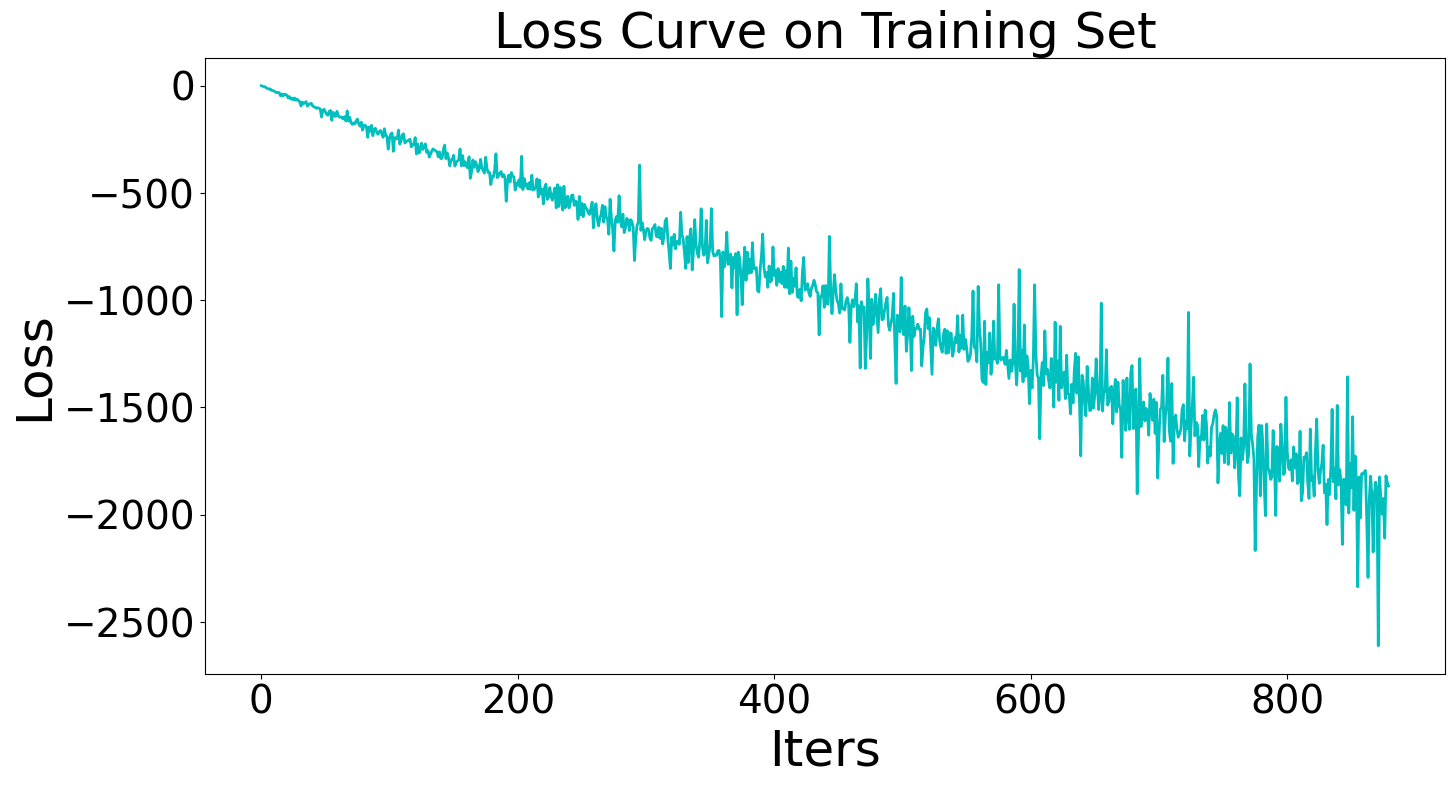

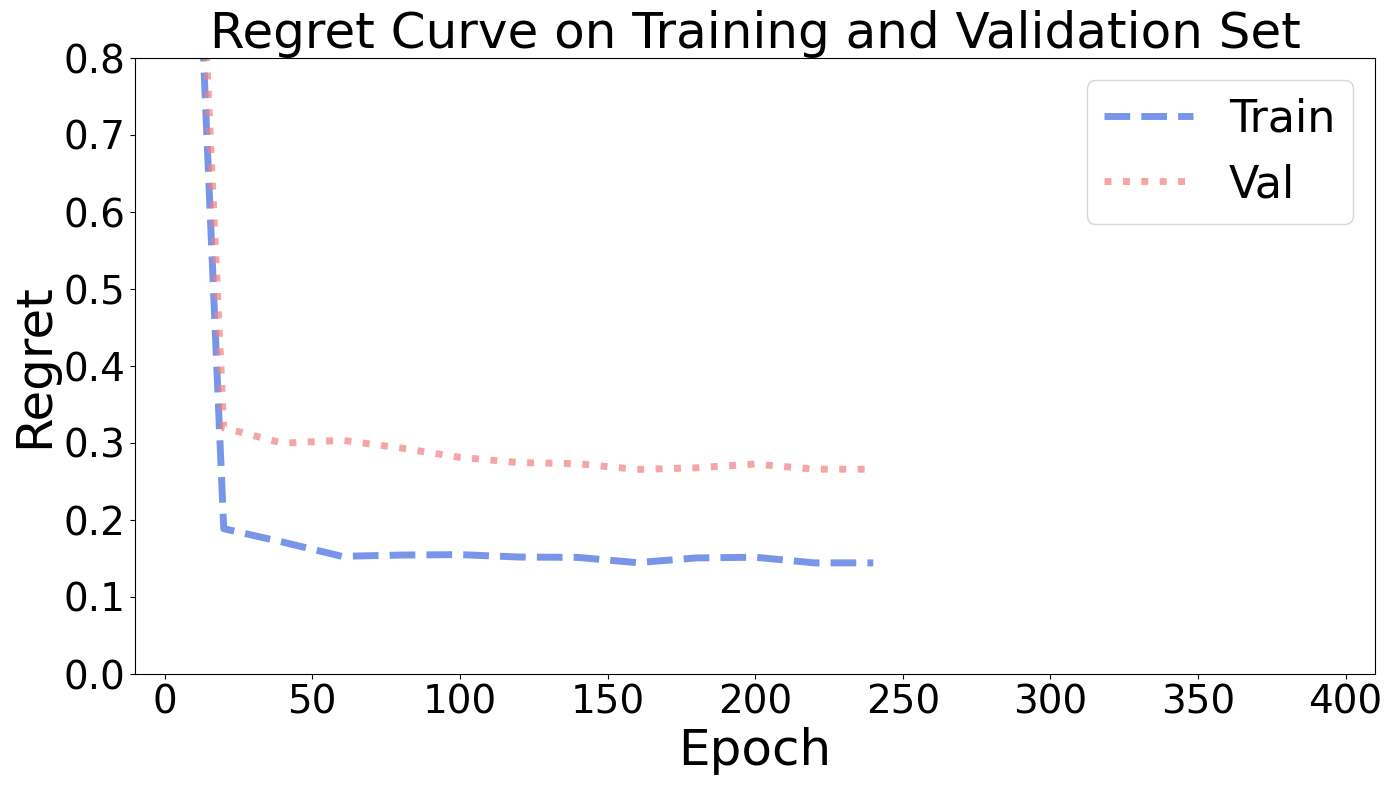

In [43]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)